# Sampling on all angles

Sample on all angles learned by model

In [1]:
import os, sys
import logging
import json
import glob
import importlib
import math
from typing import *

import torch

import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
#############

SRC_DIR = os.path.join(
    os.path.dirname(os.getcwd()), "protdiff"
)
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import beta_schedules
import datasets
import plotting
import sampling
import modelling
import utils
import angles_and_coords
import tmalign
import custom_metrics as cm

BIN_DIR = os.path.join(
    os.path.dirname(os.getcwd()), "bin"
)
assert os.path.isdir(BIN_DIR)
sys.path.append(BIN_DIR)
import train as train_bin

logging.basicConfig(level=logging.INFO)

In [2]:
# This is the version of the model trained locally with the old trRosetta angles
# MODEL_DIR = "/home/t-kevinwu/projects/protein_diffusion/temp/results"
# is_legacy = True

# This is the version of the model trained on singularity with the old trRosetta angles
# MODEL_DIR = "/home/t-kevinwu/amlt/adapted-stud/cath_full_run/results"
# is_legacy = False

# This is the version of the model with the canonical dihedral angles
# MODEL_DIR = "/home/t-kevinwu/amlt/normal-cattle/cath_full_run/results"
# is_legacy = False

# This is the version of the model with canonical dihedral angels and NO DISTANCES
# MODEL_DIR = "/home/t-kevinwu/amlt/top-bengal/cath_full_run/results"
# is_legacy = False

# This is the version of the model with canonical dihedral angles, no distances, linear warmup, centering, and 500 timesteps
MODEL_DIR = "/home/t-kevinwu/amlt/sharp-sole/cath_canonical_angles_linear_warmup_zero_centered_500_steps/results"
is_legacy = False

with open(os.path.join(MODEL_DIR, "training_args.json")) as source:
    training_args = json.load(source)
training_args


{'results_dir': '/mnt/output/projects/protdiff-cath/amlt-results/7338073080.82559-4c5fd52b-2db2-4245-9b41-59ba6945f359/results',
 'angles_definitions': 'canonical_angles_only',
 'shift_angles_zero_twopi': False,
 'zero_center': True,
 'noise_prior': 'gaussian',
 'timesteps': 500,
 'variance_schedule': 'linear',
 'variance_scale': 1.0,
 'implementation': 'huggingface_encoder',
 'time_encoding': 'gaussian_fourier',
 'num_hidden_layers': 12,
 'hidden_size': 384,
 'intermediate_size': 768,
 'num_heads': 12,
 'position_embedding_type': 'absolute',
 'dropout_p': 0.1,
 'decoder': 'mlp',
 'gradient_clip': 1.0,
 'batch_size': 64,
 'lr': 5e-05,
 'loss': 'smooth_l1',
 'l2_norm': 0.0,
 'l1_norm': 0.0,
 'circle_reg': 0.0,
 'min_epochs': 10000,
 'max_epochs': 10000,
 'early_stop_patience': 0,
 'lr_scheduler': 'LinearWarmup',
 'use_swa': False,
 'subset': None,
 'exhaustive_validation_t': False,
 'syn_noiser': '',
 'single_dist_debug': False,
 'single_angle_debug': -1,
 'single_timestep_debug': False

In [3]:
beta_values = beta_schedules.get_variance_schedule(
    training_args['variance_schedule'],
    training_args['timesteps'],
)
alpha_beta_values = beta_schedules.compute_alphas(beta_values)
alpha_beta_values.keys()

INFO:root:Getting linear variance schedule with 500 timesteps


dict_keys(['betas', 'alphas', 'alphas_cumprod', 'sqrt_alphas_cumprod', 'sqrt_one_minus_alphas_cumprod', 'posterior_variance'])

In [4]:
# Load in the dataset
importlib.reload(train_bin)
importlib.reload(datasets)

dset_args = dict(
    timesteps=training_args['timesteps'],
    variance_schedule=training_args['variance_schedule'],
    noise_prior=training_args['noise_prior'],
    shift_to_zero_twopi=training_args['shift_angles_zero_twopi'],
    var_scale=training_args['variance_scale'],
    toy=training_args['subset'],
    syn_noiser=training_args['syn_noiser'],
    exhaustive_t=training_args['exhaustive_validation_t'],
    single_dist_debug=training_args['single_dist_debug'],
    single_angle_debug=training_args['single_angle_debug'],
    single_time_debug=training_args['single_timestep_debug'],
)
if 'angles_definitions' in training_args:
    dset_args['angles_definitions'] = training_args['angles_definitions']
if 'zero_center' in training_args:
    dset_args['zero_center'] = training_args['zero_center']
else:
    dset_args['zero_center'] = False  # Old default value

train_dset, valid_dset, test_dset = train_bin.get_train_valid_test_sets(**dset_args)

INFO:root:Loading cached full dataset from /home/t-kevinwu/protdiff/protdiff/cache_canonical_structures.pkl
INFO:root:Split train contains 25224 structures
INFO:root:Offsetting features ['phi', 'psi', 'omega', 'tau'] by means [ 1.31025441 -1.45154962  0.02994127  3.13109522  1.94045902]
INFO:root:Length of angles: 9-1202, mean 152.32354107199492
INFO:root:CATH canonical angles only dataset with ['phi', 'psi', 'omega', 'tau'] (subset idx [1, 2, 3, 4])
INFO:root:Loading cached full dataset from /home/t-kevinwu/protdiff/protdiff/cache_canonical_structures.pkl
INFO:root:Split validation contains 3153 structures
INFO:root:Offsetting features ['phi', 'psi', 'omega', 'tau'] by means [ 1.30976295 -1.45174795  0.02562708  3.13114174  1.94057133]
INFO:root:Length of angles: 13-773, mean 150.05962575325088
INFO:root:CATH canonical angles only dataset with ['phi', 'psi', 'omega', 'tau'] (subset idx [1, 2, 3, 4])
INFO:root:Loading cached full dataset from /home/t-kevinwu/protdiff/protdiff/cache_can

In [5]:
train_dset.dset.feature_names['angles']

['phi', 'psi', 'omega', 'tau']

In [6]:
select_by_attn = lambda x: x['angles'][x['attn_mask'] != 0]

# Select the un-noised angles
train_values = [select_by_attn(train_dset.dset.__getitem__(i, ignore_zero_center=True)) for i in range(len(train_dset))]

train_values_stacked = torch.cat(train_values, dim=0)
cm.wrapped_mean(train_values_stacked.numpy(), axis=0)

array([-1.4526342 ,  0.03245352,  3.1311104 ,  1.9330573 ], dtype=float32)

In [7]:
train_values_stacked.shape

torch.Size([3832103, 4])

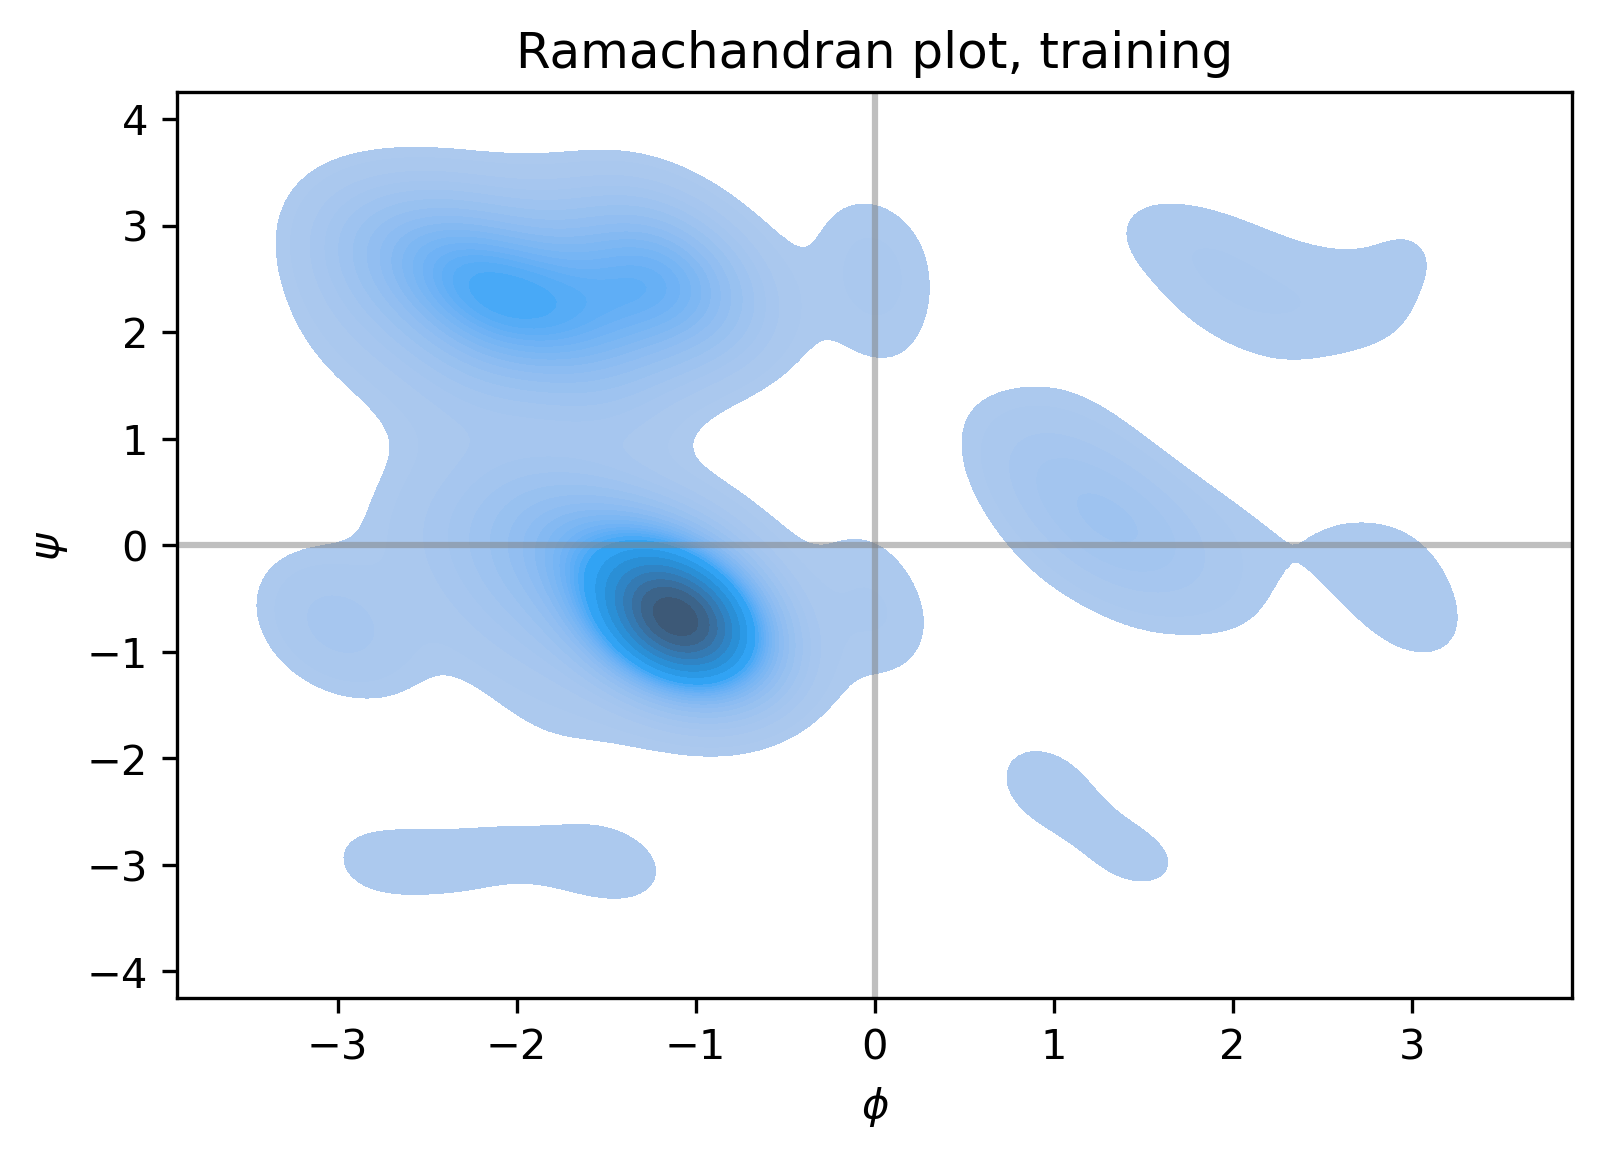

In [8]:
# Plot ramachandran plot
importlib.reload(plotting)

phi_idx = train_dset.dset.feature_names['angles'].index('phi')
psi_idx = train_dset.dset.feature_names['angles'].index('psi')

plotting.plot_joint_kde(
    train_values_stacked[:5000, phi_idx],
    train_values_stacked[:5000, psi_idx],
    xlabel="$\phi$",
    ylabel="$\psi$",
    title="Ramachandran plot, training",
).show()

In [9]:
importlib.reload(modelling)
model = modelling.BertForDiffusion.from_dir(MODEL_DIR, legacy=is_legacy).to(torch.device('cuda'))
model.n_inputs

INFO:root:Loading model assuminsg new file structure
INFO:root:Found 5 checkpoints
INFO:root:Loading weights from /home/t-kevinwu/amlt/sharp-sole/cath_canonical_angles_linear_warmup_zero_centered_500_steps/results/models/best_by_valid/epoch=391-step=154840.ckpt
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpwm_p7tyn
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpwm_p7tyn/_remote_module_non_scriptable.py
INFO:root:Mapping loss smooth_l1 to list of losses corresponding to angular [False, True, True, True]
Using loss: [<function smooth_l1_loss at 0x7f458fc250d0>, functools.partial(<function radian_smooth_l1_loss at 0x7f4587393160>, beta=0.3141592653589793), functools.partial(<function radian_smooth_l1_loss at 0x7f4587393160>, beta=0.3141592653589793), functools.partial(<function radian_smooth_l1_loss at 0x7f4587393160>, beta=0.3141592653589793)]
Using time embedding: GaussianFourierProjection()


4

In [10]:
train_dset.dset.means

array([ 1.31025441, -1.45154962,  0.02994127,  3.13109522,  1.94045902])

In [11]:
train_dset.dset.feature_is_angular['angles']

[True, True, True, True]

In [12]:
importlib.reload(sampling)

sampled = sampling.sample(
    model,
    train_dset,
    n=512,
)
sampled[0].shape

INFO:root:Starting from noise torch.Size([256, 512, 4]) with angularity [True, True, True, True] and range tensor([-3.1401, -3.1413, -3.1411, -3.1398], device='cuda:0') - tensor([3.1386, 3.1399, 3.1415, 3.1385], device='cuda:0') using cuda:0


sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Starting from noise torch.Size([256, 512, 4]) with angularity [True, True, True, True] and range tensor([-3.1397, -3.1400, -3.1409, -3.1411], device='cuda:0') - tensor([3.1393, 3.1402, 3.1381, 3.1403], device='cuda:0') using cuda:0


sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Shifting predicted values by original offset: [ 1.31025441 -1.45154962  0.02994127  3.13109522  1.94045902]


torch.Size([500, 198, 4])

In [13]:
final_sampled = [s[-1] for s in sampled]
final_sampled[0].shape

torch.Size([198, 4])

In [14]:
final_sampled_flat = torch.cat(final_sampled, dim=0).squeeze()
final_sampled_flat.shape

torch.Size([77384, 4])

In [15]:
final_sampled_flat[:3]

tensor([[ 0.5185,  2.4372,  2.6865,  1.9567],
        [-2.0734,  2.3232, -3.1259,  1.8698],
        [-1.1993, -0.4169,  3.1328,  1.9745]], dtype=torch.float64)

In [16]:
train_dset.dset.feature_names['angles']

['phi', 'psi', 'omega', 'tau']

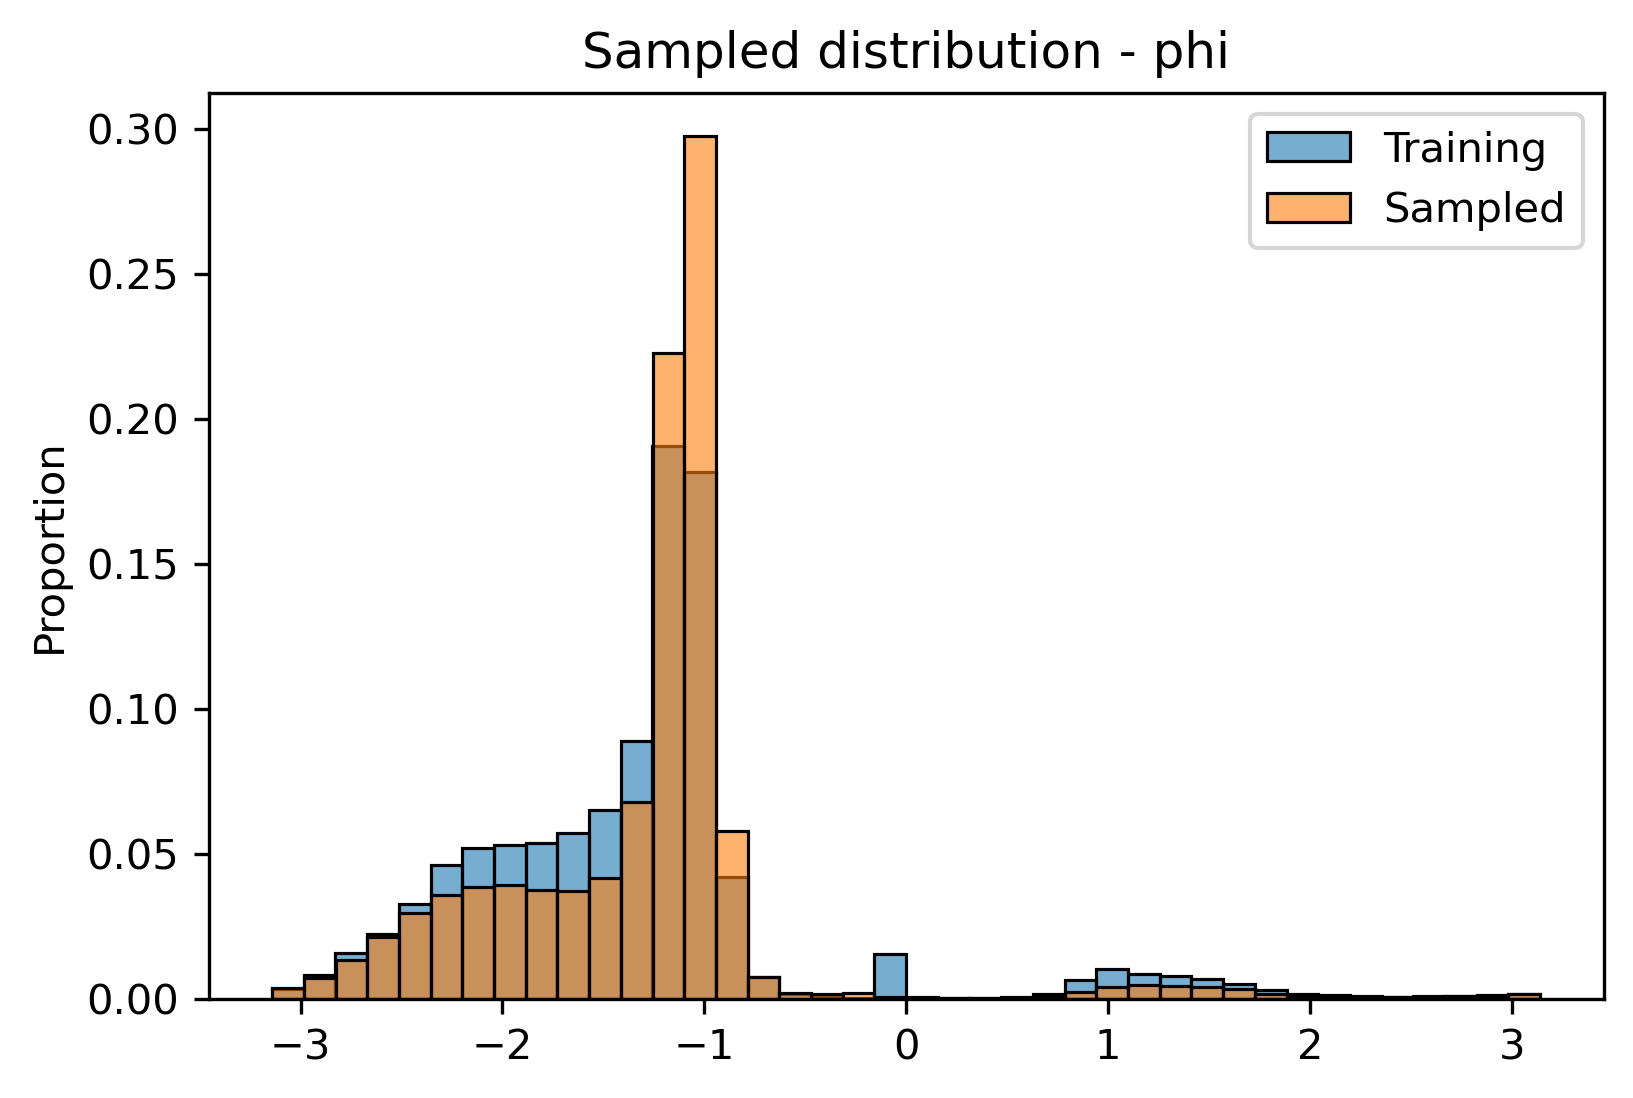

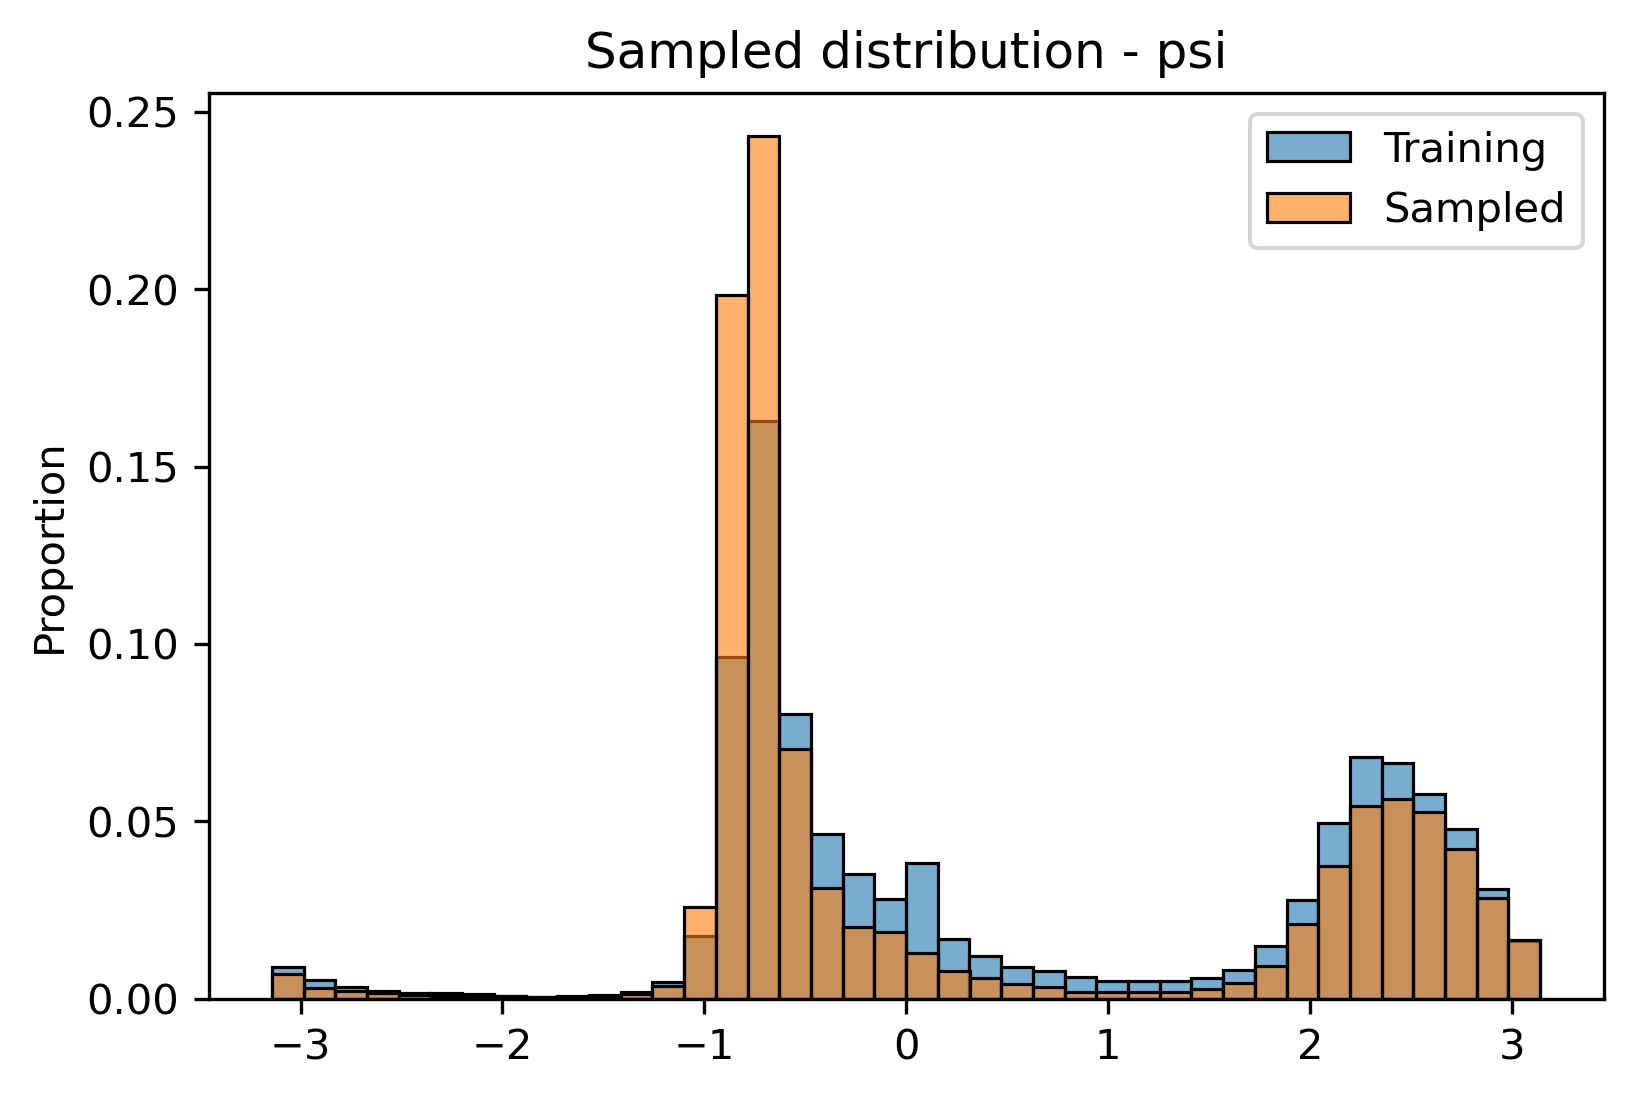

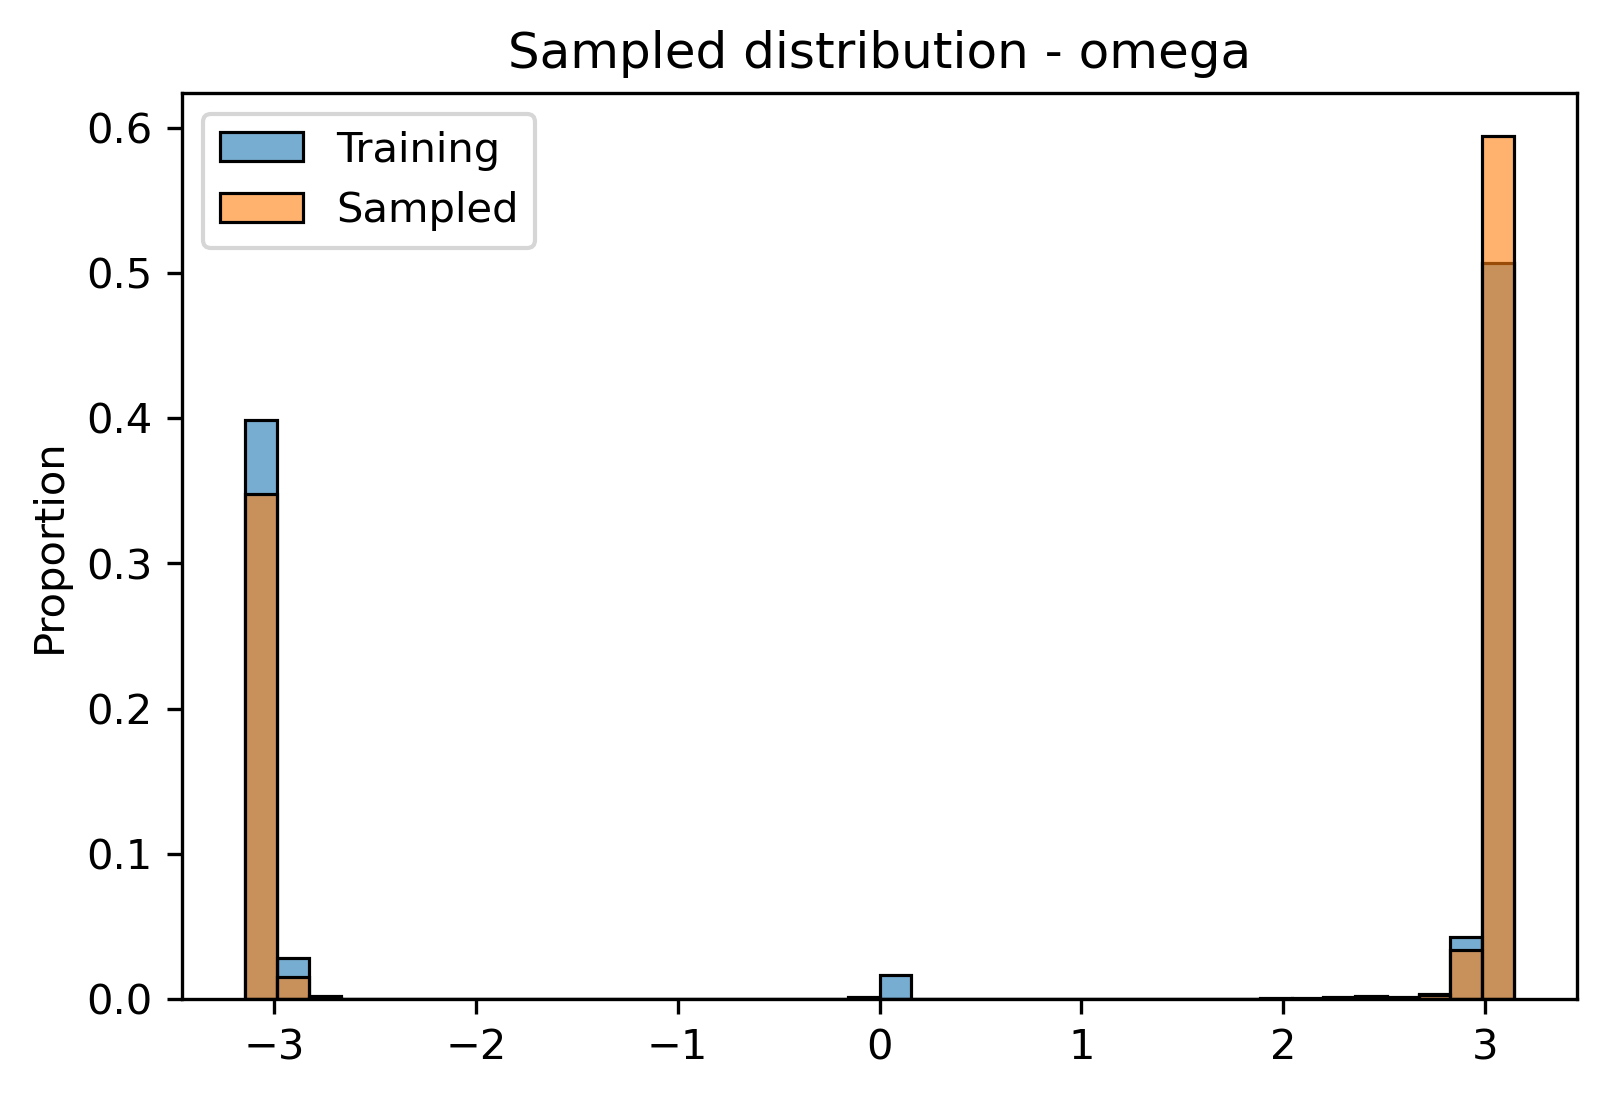

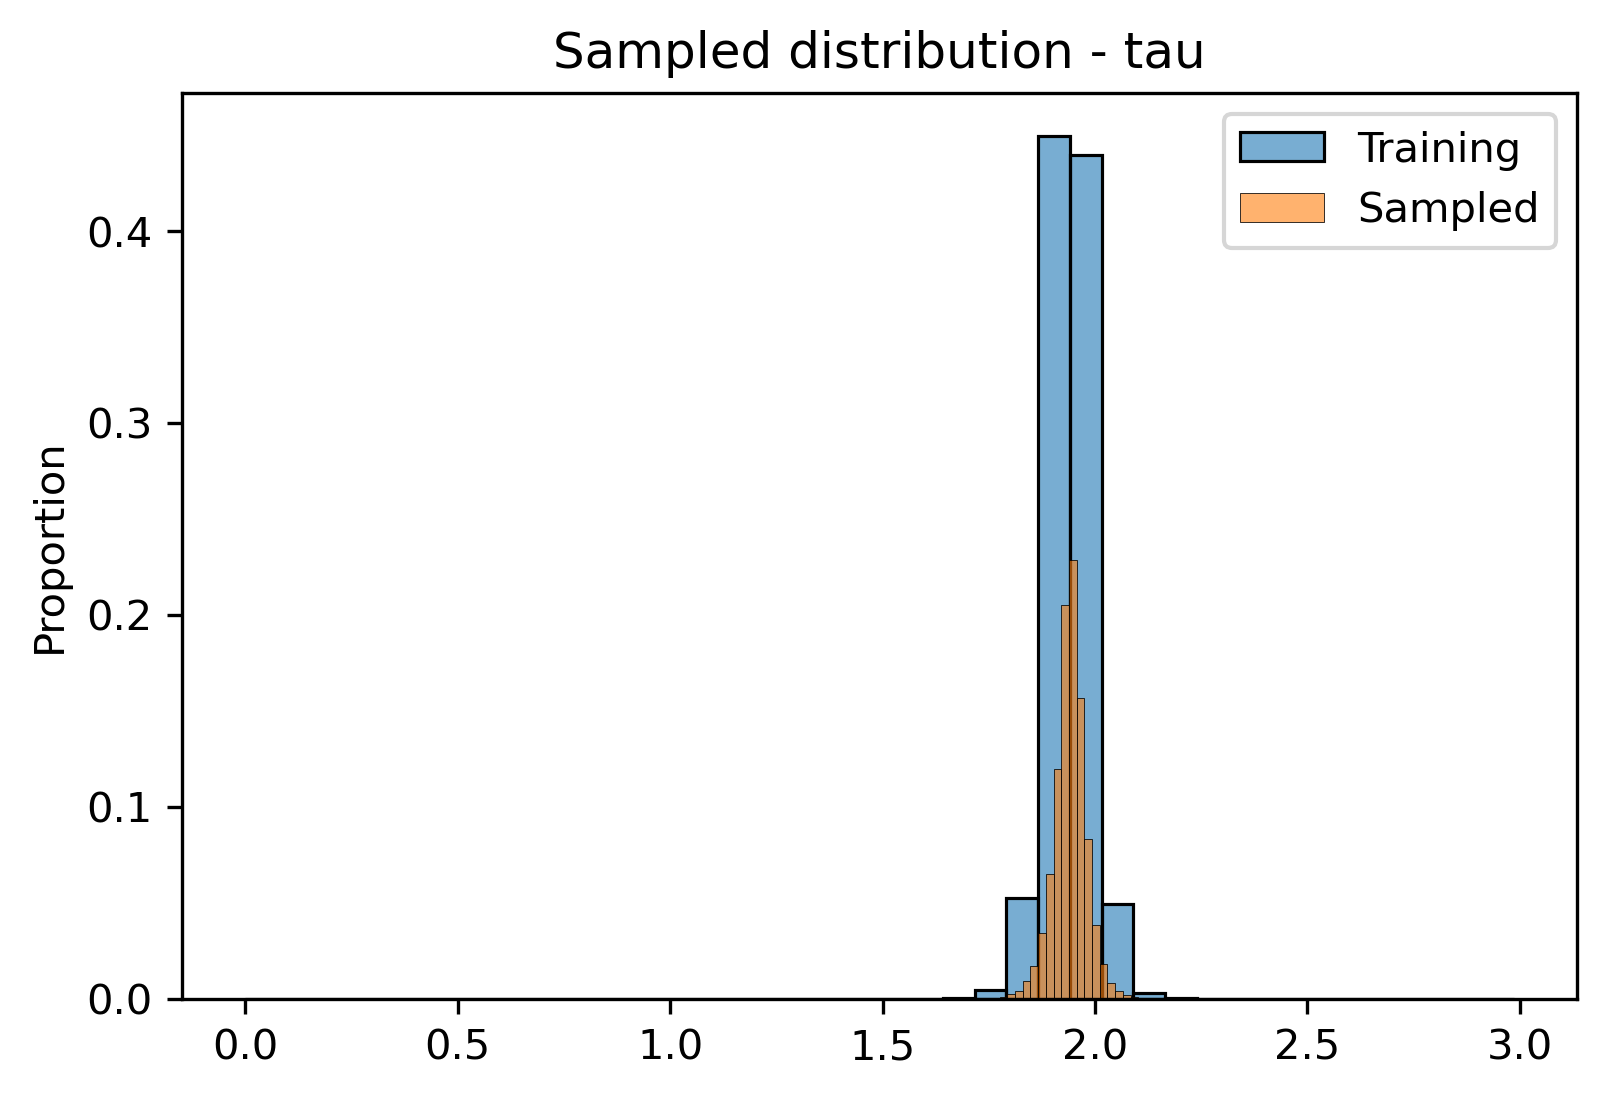

In [17]:
for i in range(model.n_inputs):
    ft_name = train_dset.dset.feature_names['angles'][i]

    fig, ax = plt.subplots(dpi=300)
    sns.histplot(train_values_stacked[:, i].numpy(), bins=40, stat='proportion',
        ax=ax, label='Training', color='tab:blue', alpha=0.6)
    sns.histplot(final_sampled_flat[:, i].numpy(), bins=40, stat='proportion', 
        ax=ax, label='Sampled', color='tab:orange', alpha=0.6)
    ax.set(title=f"Sampled distribution - {ft_name}")
    ax.legend()
    fig.show()

In [18]:
final_sampled_flat.shape

torch.Size([77384, 4])

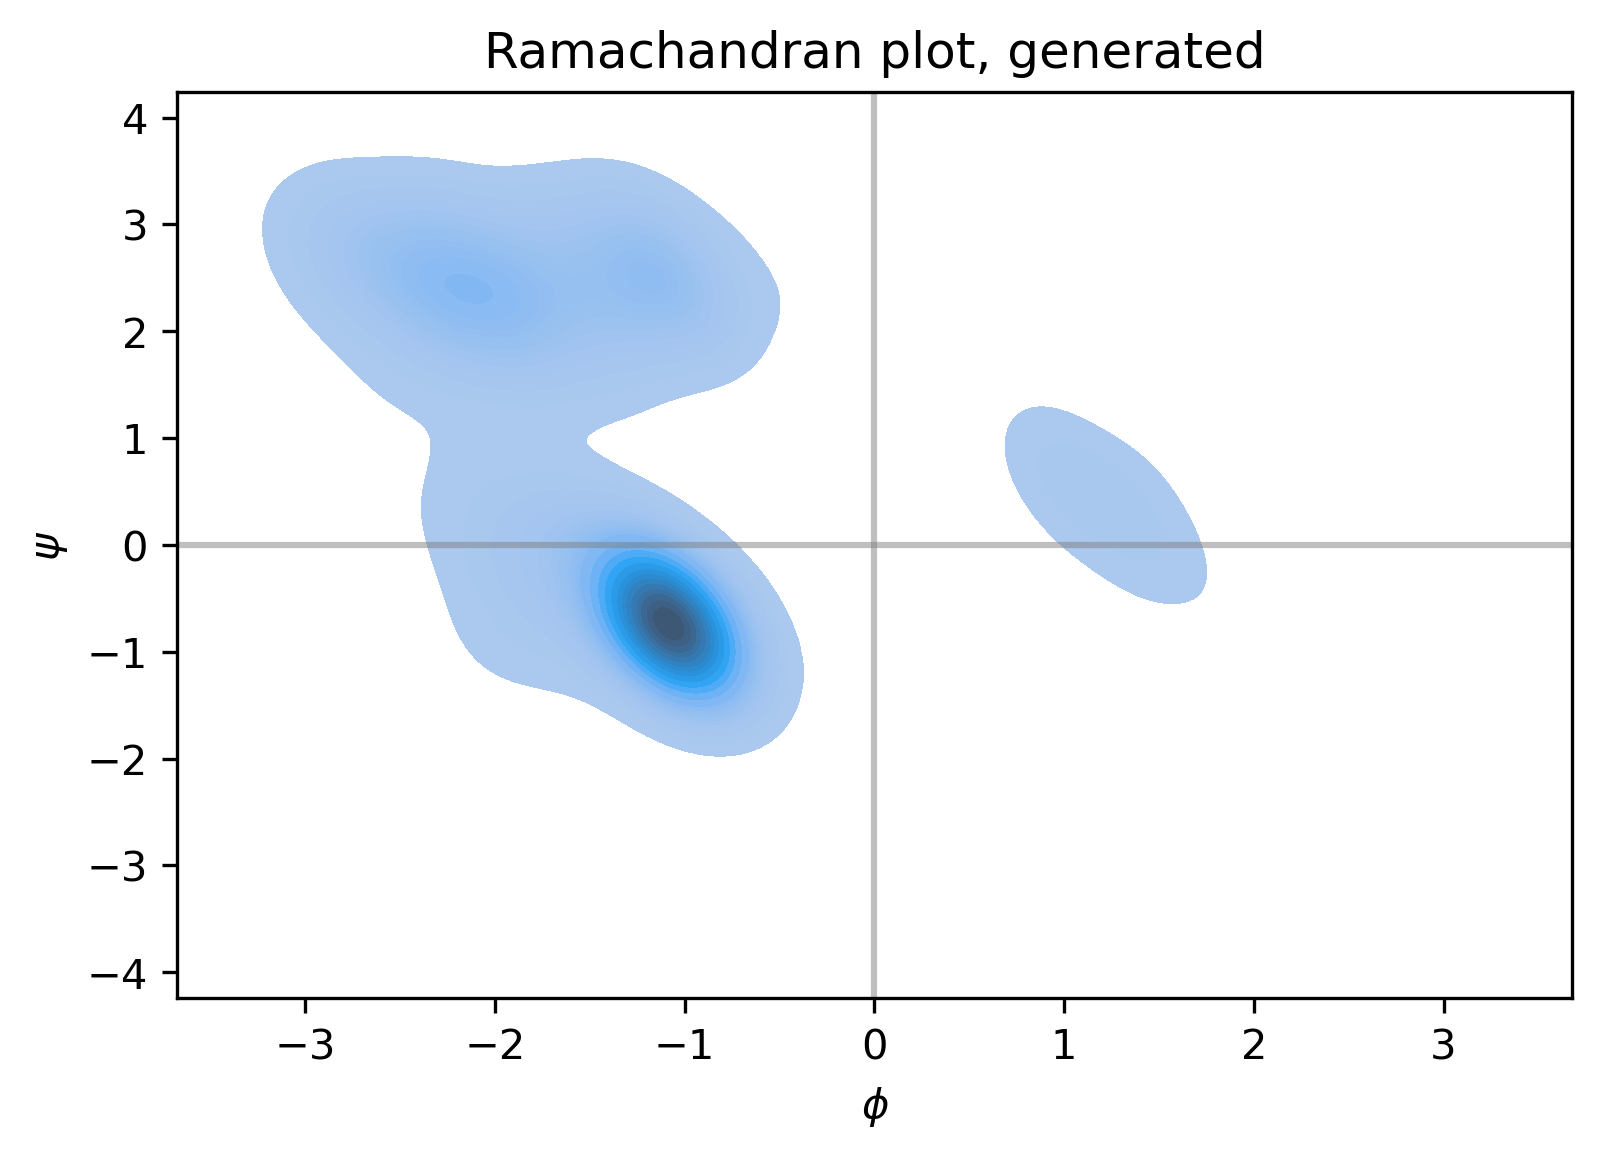

In [19]:
plotting.plot_joint_kde(
    final_sampled_flat[:5000, phi_idx],
    final_sampled_flat[:5000, psi_idx],
    xlabel="$\phi$",
    ylabel="$\psi$",
    title="Ramachandran plot, generated",
).show()

In [20]:
# Load in the unabridged dataset because we need this to sample not-predicted values

all_ft_train_dset = datasets.CathCanonicalAnglesDataset(split='train')

INFO:root:Loading cached full dataset from /home/t-kevinwu/protdiff/protdiff/cache_canonical_structures.pkl
INFO:root:Split train contains 25224 structures
INFO:root:Length of angles: 9-1202, mean 152.32354107199492


In [21]:
# Save some as PDB files
importlib.reload(angles_and_coords)
importlib.reload(tmalign)

RESULTS_DIR = "/home/t-kevinwu/projects/generated/sharp-sole-epoch-391"
os.makedirs(RESULTS_DIR, exist_ok=True)

def write_as_pdb(preds_arr:torch.Tensor, fname:str, angles_to_use:List[str] = ['phi', 'psi', 'omega', 'tau']):
    """Write the predictions as a pdb file"""
    df = pd.DataFrame(preds_arr.cpu().numpy(), columns=train_dset.dset.feature_names['angles'])
    df = df.loc[:, angles_to_use]  # Sample only dihedrals
    angles_and_coords.create_new_chain(fname, df, sampled_values_dset=all_ft_train_dset)

def write_preds_folder(final_sampled, outdir:str=RESULTS_DIR):
    """
    Write the predictions as pdb files in the given folder along with information regarding the
    tm_score for each prediction.
    """
    all_tm_scores = {}
    for i, samp in enumerate(final_sampled):
        fname = os.path.join(outdir, f"generated_{i}.pdb")
        write_as_pdb(samp, fname, angles_to_use=['phi', 'psi', 'omega', 'tau'])
        tm_score = tmalign.max_tm_across_refs(fname, train_dset.dset.filenames)
        fname_tm = os.path.join(outdir, f"generated_{i}_tm.txt")
        with open(fname_tm, 'w') as sink:
            sink.write(f"{tm_score}" + "\n")
        all_tm_scores[os.path.basename(fname)] = tm_score
    # Write a json file summarizing the tm_scores
    with open(os.path.join(outdir, "tm_scores.json"), 'w') as sink:
        json.dump(all_tm_scores, sink, indent=4)
    

write_preds_folder(final_sampled)

INFO:root:Creating new chain of 198 residues with input values ['phi', 'psi', 'omega', 'tau']
INFO:root:Matching against 25224 references using 128 workers with fast=True
INFO:root:Creating new chain of 220 residues with input values ['phi', 'psi', 'omega', 'tau']
INFO:root:Matching against 25224 references using 128 workers with fast=True
INFO:root:Creating new chain of 96 residues with input values ['phi', 'psi', 'omega', 'tau']
INFO:root:Matching against 25224 references using 128 workers with fast=True
INFO:root:Creating new chain of 87 residues with input values ['phi', 'psi', 'omega', 'tau']
INFO:root:Matching against 25224 references using 128 workers with fast=True
INFO:root:Creating new chain of 105 residues with input values ['phi', 'psi', 'omega', 'tau']
INFO:root:Matching against 25224 references using 128 workers with fast=True
INFO:root:Creating new chain of 165 residues with input values ['phi', 'psi', 'omega', 'tau']
INFO:root:Matching against 25224 references using 128

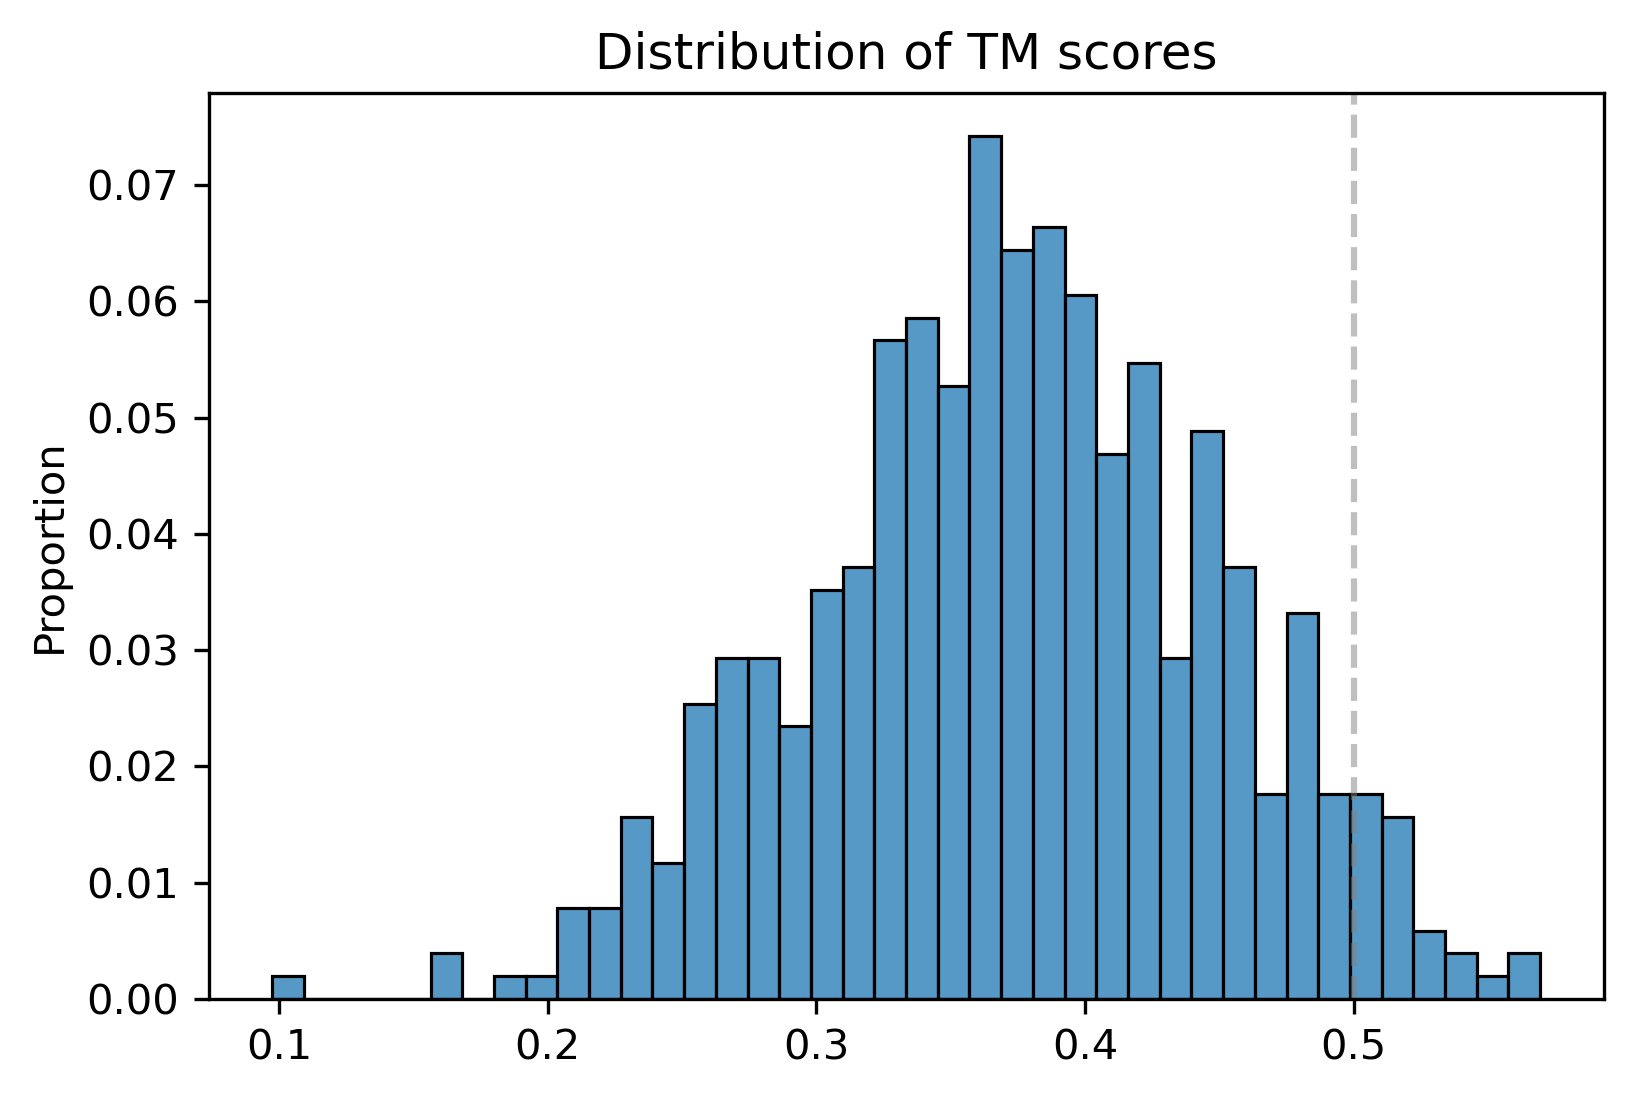

In [25]:
# Plot the distribution of tmscores

def plot_tmscores(outdir:str=RESULTS_DIR):
    """Plot the TM scores recorded in the given output directory"""
    with open(os.path.join(outdir, "tm_scores.json")) as source:
        tm_scores = json.load(source)
    fig, ax = plt.subplots(dpi=300)
    sns.histplot(list(tm_scores.values()), bins=40, stat='proportion', ax=ax)
    ax.axvline(0.5, color='grey', linestyle='--', alpha=0.5)
    ax.set(title="Distribution of TM scores")
    return fig

plot_tmscores().show()

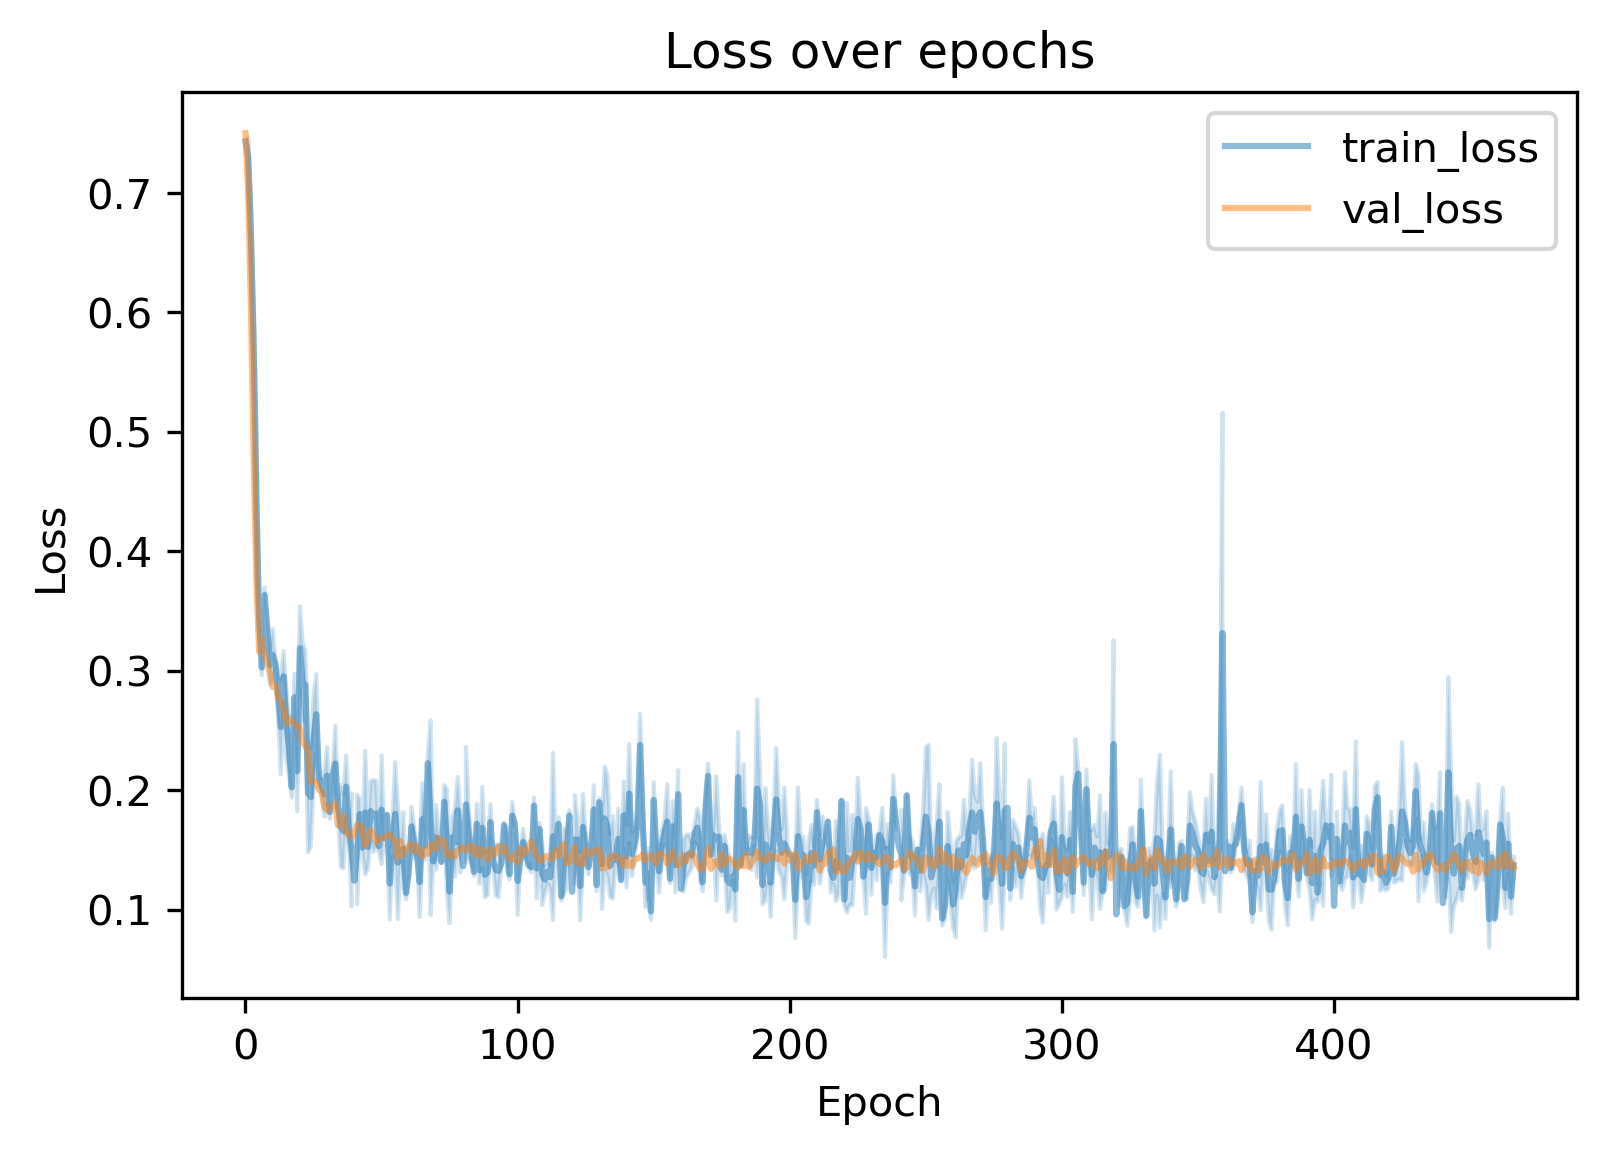

In [22]:
# Plot losses

metrics_file = os.path.join(MODEL_DIR, "logs/lightning_logs/version_0/metrics.csv")
assert os.path.isfile(metrics_file), f"Metrics file not found: {metrics_file}"

plotting.plot_losses(metrics_file, simple=True).show()

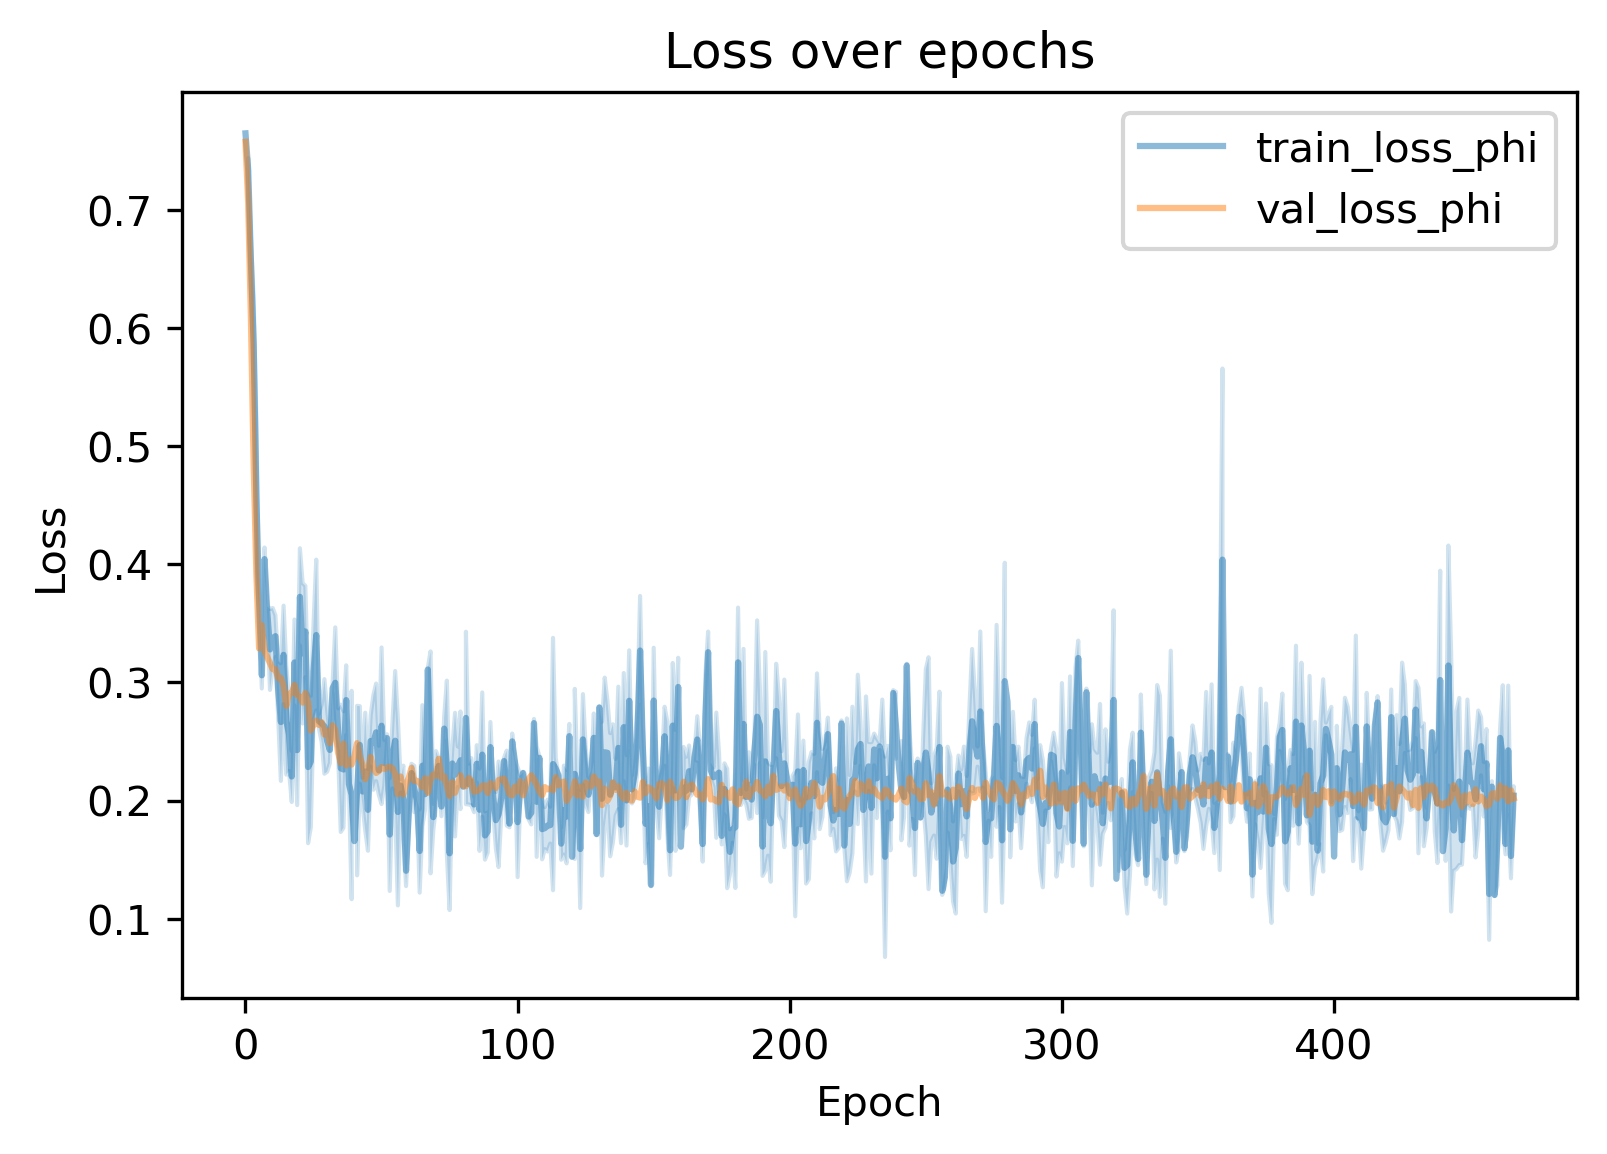

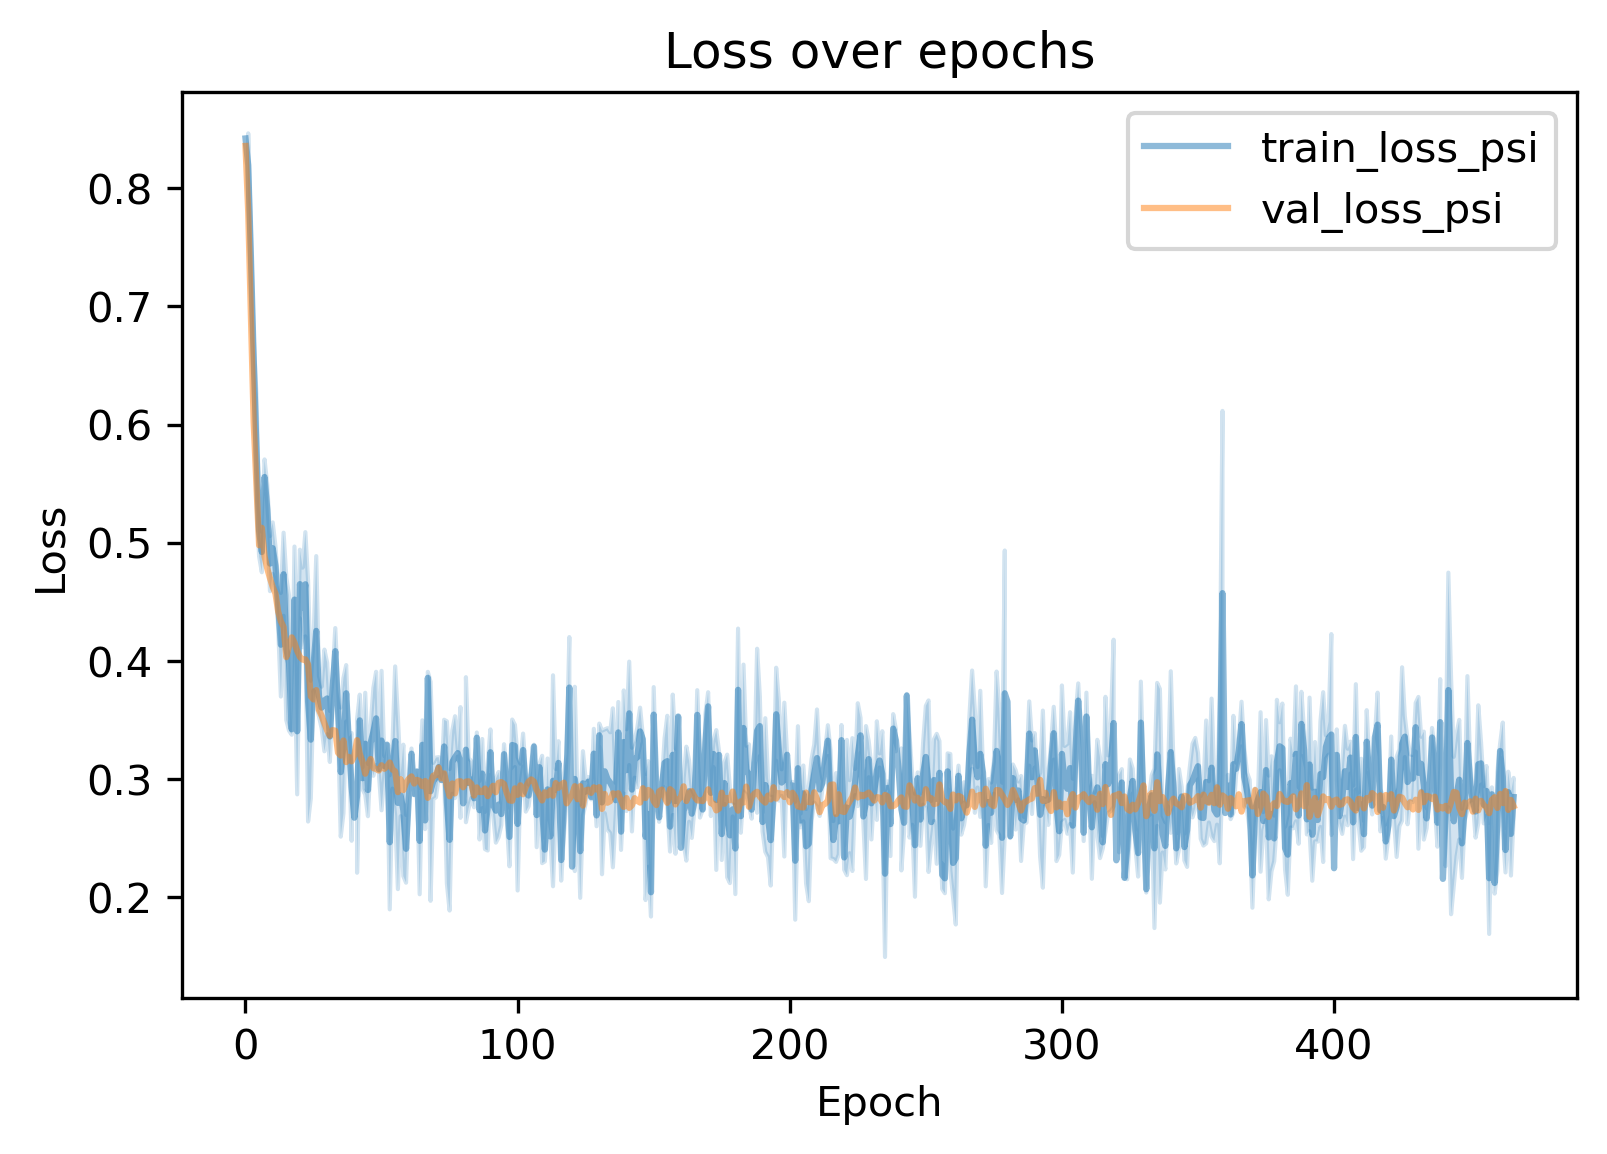

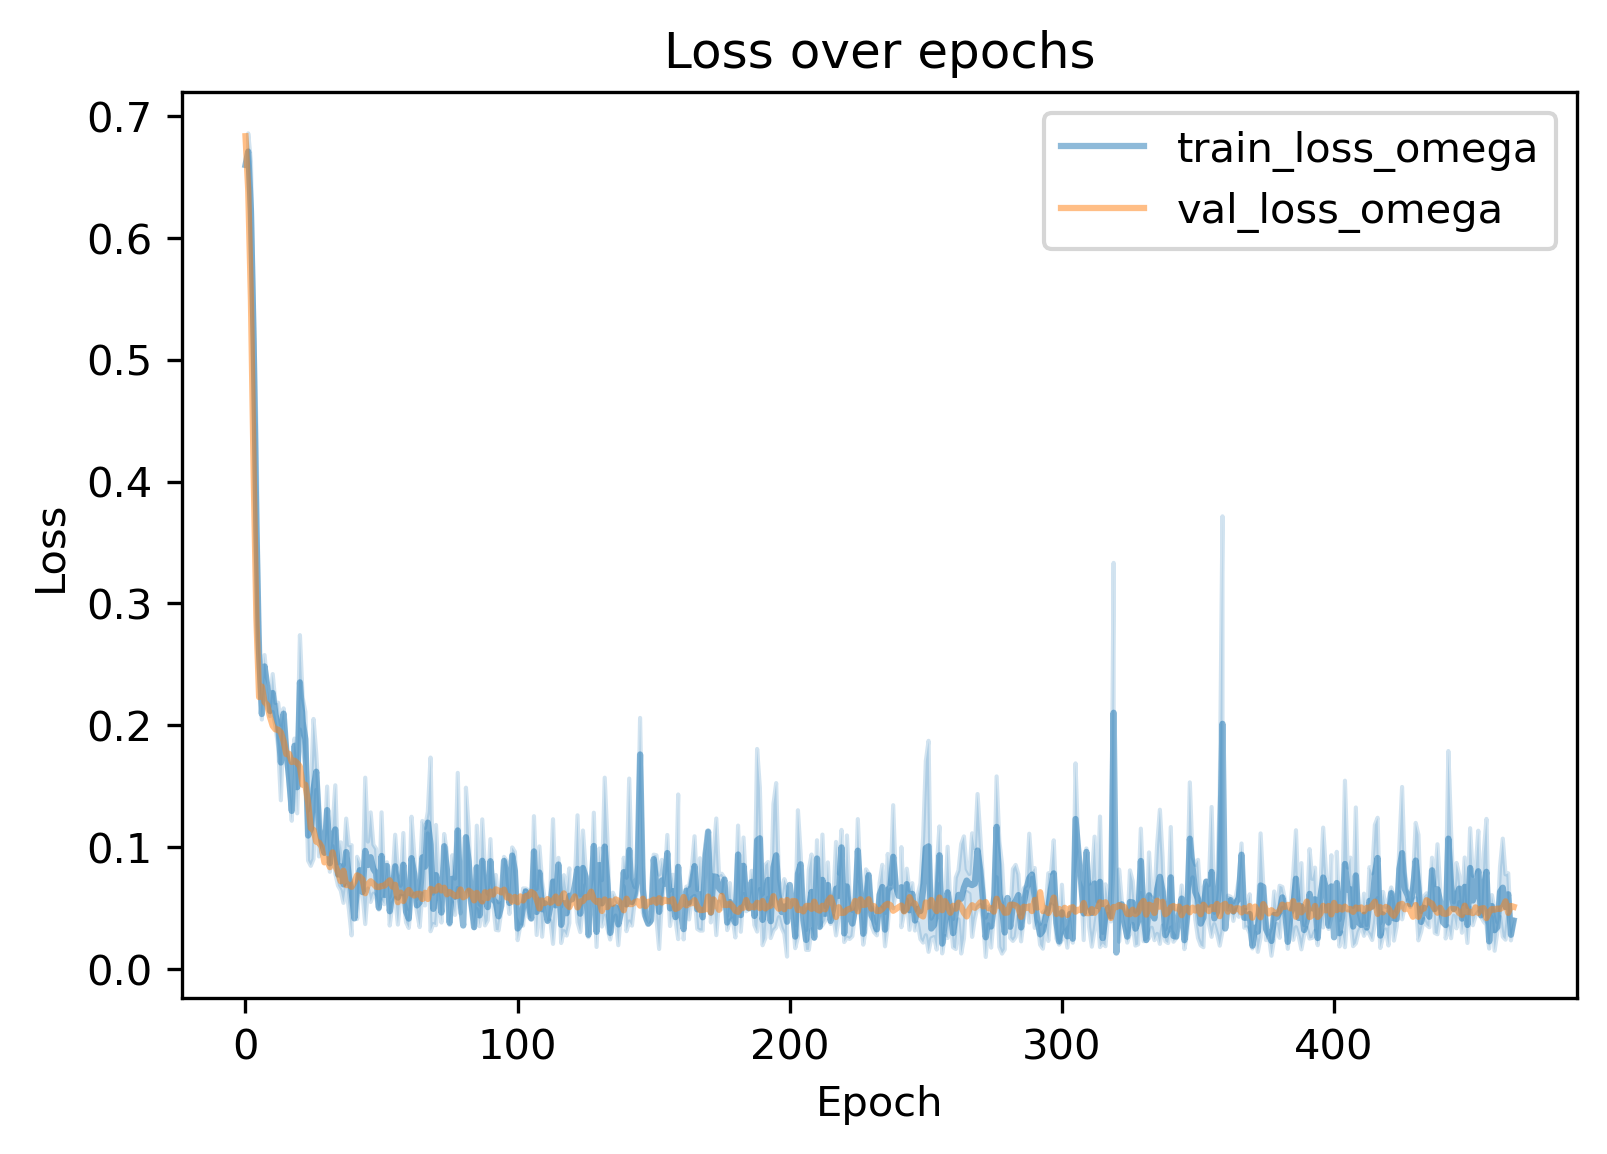

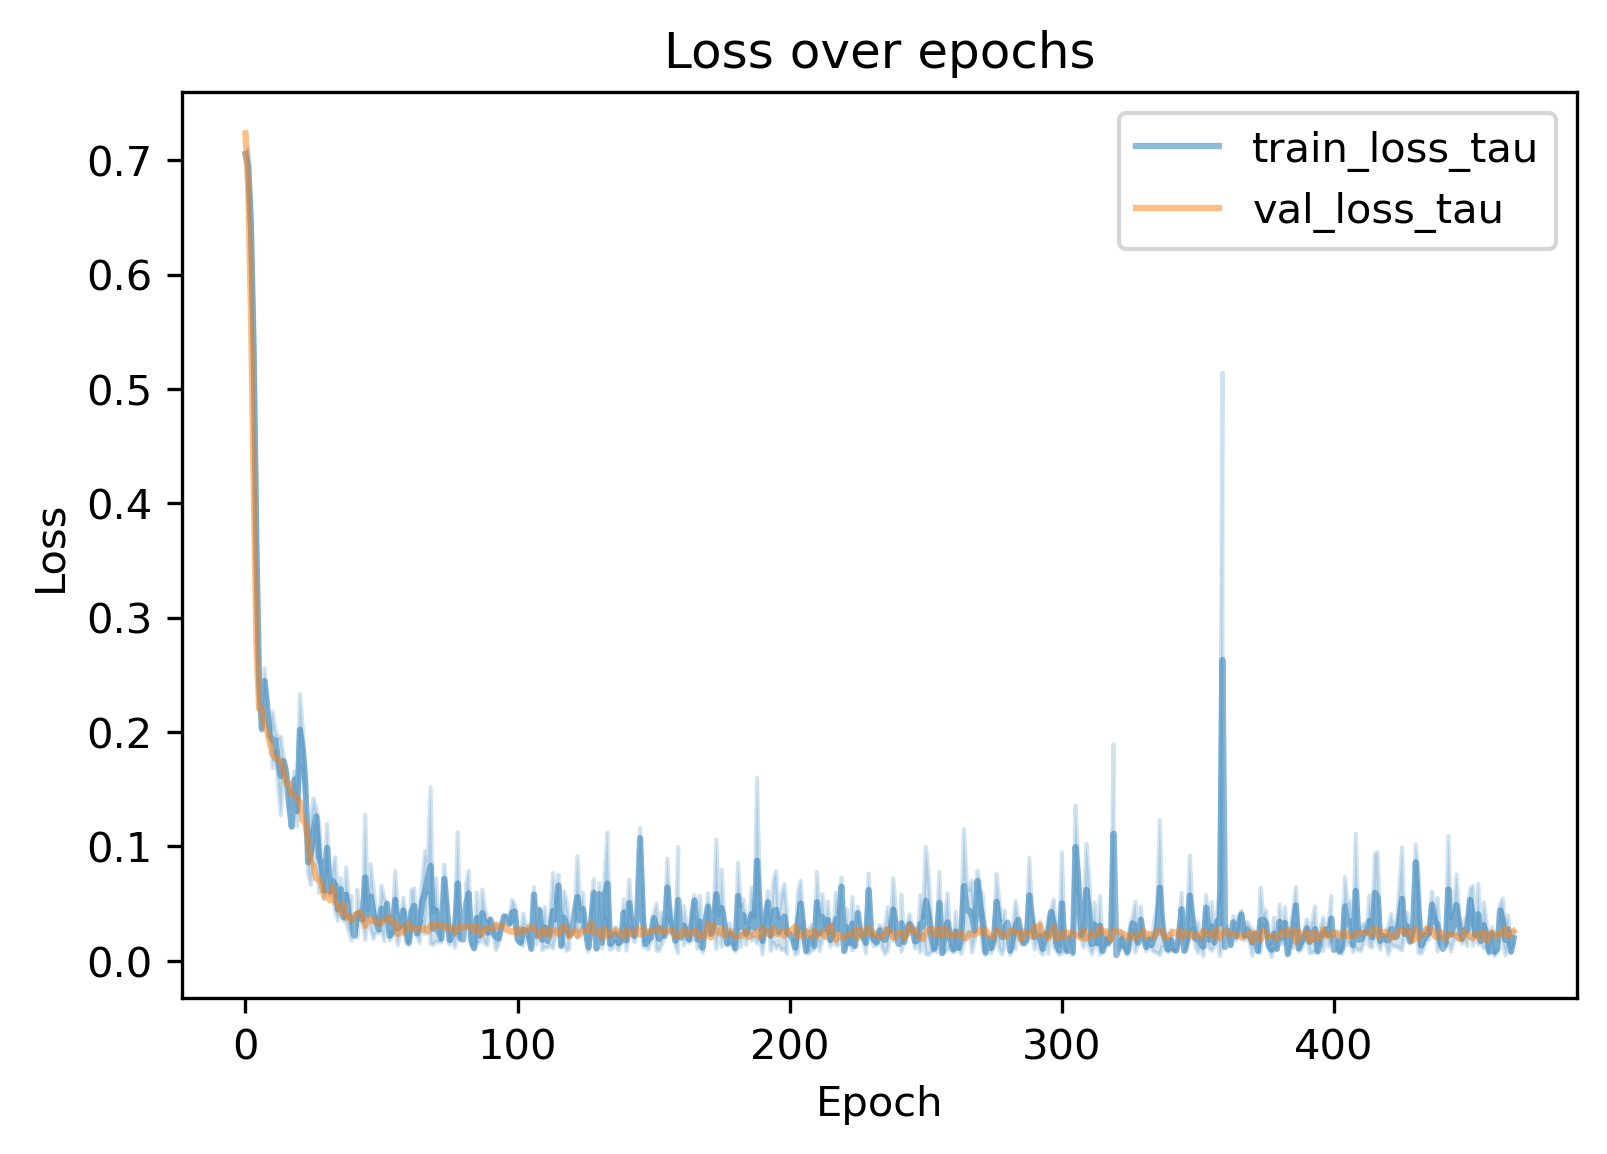

In [23]:
importlib.reload(plotting)

for feature in train_dset.dset.feature_names['angles']:
    plotting.plot_losses(metrics_file, pattern=f"loss_{feature}").show()